### Auto Encoder

In [ ]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(66)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K 
import tensorflow as tf
import cv2

In [9]:
folder_benign = 'data/benign'
folder_malignant = 'data/malignant'
def read(path):
    return np.asarray(Image.open(path).convert("RGB"))

ims_benign = [read(os.path.join(folder_benign, filename)) for filename in os.listdir(folder_benign)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant, filename)) for filename in os.listdir(folder_malignant)]
X_malignant = np.array(ims_malignant, dtype='uint8')

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.zeros(X_malignant.shape[0])

X = np.concatenate((X_benign, X_malignant), axis = 0)
y = np.concatenate((y_benign, y_malignant), axis = 0)
s = np.arange(X.shape[0])
np.random.shuffle(s)
X,y = X[s],y[s]

X_scaled = X/255.
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.20)

In [164]:
# auto encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(224,224,3)))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))#encode
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((4, 4)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))#decode
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 8)        0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 8)       

In [17]:
model.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[tf.keras.callbacks.TensorBoard("logs")])

Epoch 1/10
17/17 [==============================] - 215s 12s/step - loss: 0.6681 - val_loss: 0.6511
Epoch 2/10
17/17 [==============================] - 187s 11s/step - loss: 0.6399 - val_loss: 0.6396
Epoch 3/10
17/17 [==============================] - 179s 11s/step - loss: 0.6340 - val_loss: 0.6331
Epoch 4/10
17/17 [==============================] - 184s 11s/step - loss: 0.6256 - val_loss: 0.6201
Epoch 5/10
17/17 [==============================] - 189s 11s/step - loss: 0.6124 - val_loss: 0.6086
Epoch 6/10
17/17 [==============================] - 181s 11s/step - loss: 0.6033 - val_loss: 0.6038
Epoch 7/10
17/17 [==============================] - 180s 10s/step - loss: 0.6000 - val_loss: 0.6009
Epoch 8/10
17/17 [==============================] - 184s 11s/step - loss: 0.5971 - val_loss: 0.5986
Epoch 9/10
17/17 [==============================] - 174s 10s/step - loss: 0.5951 - val_loss: 0.5966
Epoch 10/10
17/17 [==============================] - 177s 10s/step - loss: 0.5934 - val_loss: 0.5945

In [156]:
# similarity calculation 
def calculate(image1, image2):
    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree

def similarity(image1, image2):
    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(image2.astype(np.float32), cv2.COLOR_RGB2BGR)
    sub_image1 = cv2.split(image1)
    sub_image2 = cv2.split(image2)
    sub_data = 0
    for im1, im2 in zip(sub_image1, sub_image2):
        sub_data += calculate(im1, im2)
    return str(sub_data*100/3)

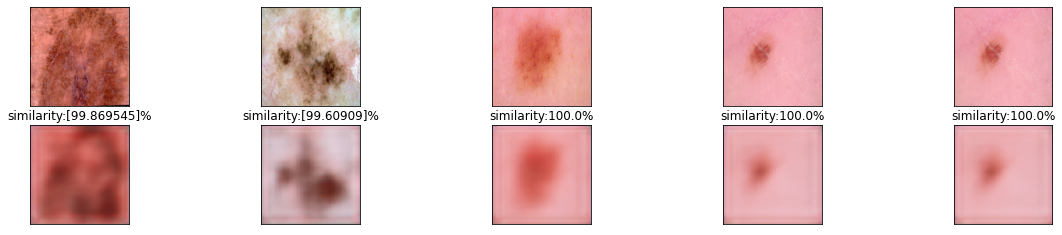

In [168]:
decoded_imgs = autoencoder.predict(X_test)
n = np.random.randint(0,100,5)
plt.figure(figsize=(20, 4))

for i,j in enumerate(n):
    i += 1
    
    ax = plt.subplot(2, 5, i)
    plt.imshow(X_test[j])
    plt.plot()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 5, i+5)
    plt.imshow(decoded_imgs[j])
    plt.plot()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('similarity:'+similarity(decoded_imgs[j],X_test[j])+'%')
plt.show()

### EHR

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

text = '''
Have you tried to run a marathon with no practice?
I hope not. You might pull a muscle.
You need to start small in order to achieve something big like that.
When it comes to learning English, what if I told you that you can understand big ideas with just a little bit of text?
You do not need to wait several years to deal with complex ideas.
Just because you are learning a language does not mean you need to limit your thinking.
Stories are all about going beyond reality. It is no wonder that they let you understand big ideas with only a little bit of English reading practice.
But this works better when you’re reading better stories.
I am talking about award-winning short stories, told using language easily understood by English beginner learners. These will not only improve your English reading but also open your mind to different worlds.
'''

words = word_tokenize(text)

word_freq = {}

for word in words:
    word = word.lower()
    if word not in stopwords.words('english'):
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
            
sentences = sent_tokenize(text)
sen_val = {}

for sen in sentences:
    for word,freq in word_freq.items():
        if word in sen.lower():
            if sen in sen_val:
                sen_val[sen] += freq
            else:
                sen_val[sen] = freq

value = 0
for sen in sen_val:
    value += sen_val[sen]
    
arg = int(value/len(sen_val))

summary = ''
for sen in sentences:
    if sen in sen_val:
        if sen_val[sen] > 1.5*arg:
            summary += " " + sen
print(summary)

 It is no wonder that they let you understand big ideas with only a little bit of English reading practice. I am talking about award-winning short stories, told using language easily understood by English beginner learners.
